In [14]:
import sys

sys.path.append("..")

In [144]:
import random
from typing import Optional

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

tqdm.pandas()

In [16]:
class Dataset(torch.utils.data.Dataset):
    """
    self.features = [(user_id, [context_item_id])]
    self.target_item = [target_item_id]
    self.clv = [clv_value]
    """

    def __init__(
        self,
        sequences: dict[int, list[int]],
        clv_dict: dict[int, float],
        target_items: dict[int, list[int]],
        context_length: int = 10,
    ):
        """
        Args:
            sequences (dict[int, list[int]]):
                ユーザごとの購買商品系列
                [user_id : user_items]
            clv_dict (dict[int, float]):
                ユーザのCLV
                [user_id : clv_value]
            context_length (int, optional):
                予測時に参照する直前のアイテムの個数
        """
        self.features = []
        self.target_items = []
        self.clv = []

        for user_idx, sequence in tqdm(sequences.items()):
            self.features.append((user_idx, sequence))
            self.target_items.append(target_items[user_idx] if user_idx in target_items else [])
            self.clv.append(clv_dict[user_idx] if user_idx in clv_dict else 0)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int) -> tuple[tuple[int, list[int]], list[int], float]:
        return self.features[idx], self.target_items[idx], self.clv[idx]

In [17]:
def create_user_features(feature_df: pd.DataFrame, split_date: pd.Timestamp):
    # 最新購買日
    recency = split_date - feature_df.groupby("user_id").timestamp.max()
    recency = (recency.dt.days / 365).rename("recency")
    recency[recency >= 1] = 1

    # 総購買数
    frequency = feature_df.user_id.value_counts().sort_index().rename("frequency")
    frequency /= 500
    frequency[frequency >= 1] = 1

    # 利用期間
    tenure = (
        feature_df.groupby("user_id").timestamp.max()
        - feature_df.groupby("user_id").timestamp.min()
    )
    tenure = (tenure.dt.days / 365).rename("tenure")
    tenure[tenure >= 1] = 1

    user_features = pd.merge(recency, tenure, on="user_id", how="left")
    user_features = pd.merge(user_features, frequency, on="user_id", how="left")
    return user_features


def create_targets(target_df: pd.DataFrame):
    # CLV
    clv_dict = target_df.user_id.value_counts().sort_index().to_dict()

    # CV商品
    target_items = target_df.groupby("user_id").item_id.agg(list).to_dict()
    return clv_dict, target_items

In [18]:
def encode_user_item_id(
    interaction_df: pd.DataFrame,
) -> tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
    user_le = LabelEncoder().fit(interaction_df.user_id)
    item_le = LabelEncoder().fit(interaction_df.item_id)

    interaction_df.user_id = user_le.transform(interaction_df.user_id)
    interaction_df.item_id = item_le.transform(interaction_df.item_id)

    return interaction_df, user_le, item_le

def create_dataset(
    interaction_df: pd.DataFrame,
    split_date: pd.Timestamp | str,
    context_length: int = 10,
) -> tuple[Dataset, torch.Tensor, torch.Tensor]:
    feature_df = (
        interaction_df[interaction_df.timestamp < split_date]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )
    target_df = (
        interaction_df[interaction_df.timestamp >= split_date]
        .sort_values("timestamp")
        .reset_index(drop=True)
    )

    sequences = feature_df.groupby("user_id").item_id.agg(list).to_dict()
    user_features = create_user_features(feature_df=feature_df, split_date=split_date)
    user_embedding_weight = torch.from_numpy(user_features.values.astype(np.float32))

    clv_dict, target_items = create_targets(target_df=target_df)

    dataset = Dataset(
        sequences=sequences,
        clv_dict=clv_dict,
        target_items=target_items,
        context_length=context_length,
    )
    return dataset, user_embedding_weight

In [92]:
class Model(torch.nn.Module):
    def __init__(
        self,
        user_embedding_weight: torch.Tensor,
        item_size: int,
        num_layers: int = 4,
        d_model: int = 64,
        dim_feedforward: int = 128,
        nhead: int = 4,
    ):
        super().__init__()
        user_size, user_feature_dim = user_embedding_weight.shape

        self.user_feature = torch.nn.Embedding(user_size, user_feature_dim)
        self.user_feature.weight = torch.nn.Parameter(user_embedding_weight)
        self.user_feature.weight.require_grad = False

        self.user_embedding = torch.nn.Linear(user_feature_dim, d_model)

        self.item_embedding = torch.nn.Embedding(item_size, d_model)
        self.item_embedding.weight.require_grad = False

        self.transformer_layer = torch.nn.TransformerEncoder(
            encoder_layer=torch.nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                batch_first=True,
            ),
            num_layers=num_layers,
        )
        self.projection_clv = torch.nn.Linear(d_model, 1)
        self.projection_target = torch.nn.Linear(d_model, 1)

    def forward(self, user_id: torch.Tensor, item_indices: torch.Tensor):
        f_u = self.user_feature.forward(user_id)
        e_u = self.user_embedding.forward(f_u)
        H_v = self.item_embedding.forward(item_indices)
        H = torch.cat((e_u.unsqueeze(1), H_v), dim=1)
        H = self.transformer_layer.forward(H)

        y_clv = torch.sigmoid(self.projection_clv.forward(H[:, 0]))
        y_target = torch.sigmoid(self.projection_target.forward(H[:, -1]))

        return y_clv.squeeze(), y_target.squeeze()

In [20]:
interaction_df = pd.read_csv("../data/ml-25m/ratings.csv").rename(
    columns={"userId": "user_id", "movieId": "item_id"}
)
interaction_df.timestamp = pd.to_datetime(interaction_df.timestamp, unit="s")
interaction_df

,user_id,item_id,rating,timestamp
0,1,296,5.0,2006-05-17 15:34:04
1,1,306,3.5,2006-05-17 12:26:57
2,1,307,5.0,2006-05-17 12:27:08
3,1,665,5.0,2006-05-17 15:13:40
4,1,899,3.5,2006-05-17 12:21:50
...,...,...,...,...
25000090,162541,50872,4.5,2009-04-28 21:16:12
25000091,162541,55768,2.5,2009-04-28 20:53:18
25000092,162541,56176,2.0,2009-04-28 20:31:37
25000093,162541,58559,4.0,2009-04-28 21:17:14


In [21]:
last_review_date = pd.to_datetime("2015/01/01")
train_split_date = pd.to_datetime("2017/01/01")
test_split_date = pd.to_datetime("2018/01/01")

first_review = interaction_df.groupby("user_id").timestamp.min()
last_review = interaction_df.groupby("user_id").timestamp.max()
target_users = set(last_review[(first_review < train_split_date)].index) & set(
    last_review[(last_review_date <= last_review)].index
)

train_interaction_df = interaction_df[interaction_df.user_id.isin(target_users)].reset_index(drop=True)

In [113]:
context_length = 10
d_model = 32
batch_size = 64
nhead = 4
epochs = 5
lr = 1e-3
sample_size = 5

train_interaction_df, user_le, item_le = encode_user_item_id(
    interaction_df=train_interaction_df
)

# FIXME: 2018年以降の予測対象に含んでいる
train_dataset, train_user_embedding_weight = create_dataset(
    interaction_df=train_interaction_df,
    split_date=train_split_date,
    context_length=context_length,
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x
)

100%|██████████| 25093/25093 [00:00<00:00, 141218.59it/s]


In [114]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [115]:
model = Model(
    user_embedding_weight=train_user_embedding_weight,
    item_size=len(item_le.classes_),
    d_model=d_model,
    nhead=nhead,
)
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    loss_sum = 0
    for batch in tqdm(train_dataloader):
        user_ids = []
        item_indices = []
        labels = []
        for (user_id, user_context_items), target_items, clv in batch:
            context_items = []
            for _ in range(9):
                context_items.append(
                    user_context_items[random.randrange(len(user_context_items))]
                )

            # 正例
            for _ in range(min(sample_size, len(target_items))):
                v = list(context_items)
                v.append(target_items[random.randrange(0, len(target_items))])
                user_ids.append(user_id)
                item_indices.append(v)
                labels.append(1)

            # 負例
            for _ in range(sample_size):
                v = list(context_items)
                v.append(random.randrange(len(item_le.classes_)))
                user_ids.append(user_id)
                item_indices.append(v)
                labels.append(0)

        user_ids = torch.LongTensor(user_ids).to(device)
        item_indices = torch.LongTensor(item_indices).to(device)
        labels = torch.FloatTensor(labels).to(device)
        y_clv, y_target = model.forward(user_ids, item_indices)

        loss = torch.nn.functional.binary_cross_entropy(y_target, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() / labels.size(0)

    loss_sum /= len(train_dataloader)
    print(f"[{epoch + 1}/{epochs}] loss: {loss_sum:>7f}")

100%|██████████| 393/393 [01:01<00:00,  6.38it/s]


[1/5] loss: 0.001072


100%|██████████| 393/393 [00:27<00:00, 14.25it/s]


[2/5] loss: 0.000948


100%|██████████| 393/393 [00:25<00:00, 15.14it/s]


[3/5] loss: 0.000800


100%|██████████| 393/393 [00:28<00:00, 13.63it/s]


[4/5] loss: 0.000670


100%|██████████| 393/393 [00:24<00:00, 16.03it/s]

[5/5] loss: 0.000626


In [138]:
model.eval()

y_pred = []
y_true = []

for batch in tqdm(train_dataloader):
    user_ids = []
    item_indices = []
    labels = []
    for (user_id, user_context_items), target_items, clv in batch:
        context_items = []
        for _ in range(9):
            context_items.append(
                user_context_items[random.randrange(len(user_context_items))]
            )

        # 正例
        for _ in range(min(sample_size, len(target_items))):
            v = list(context_items)
            v.append(target_items[random.randrange(0, len(target_items))])
            user_ids.append(user_id)
            item_indices.append(v)
            labels.append(1)

        # 負例
        for _ in range(sample_size):
            v = list(context_items)
            v.append(random.randrange(len(item_le.classes_)))
            user_ids.append(user_id)
            item_indices.append(v)
            labels.append(0)

    user_ids = torch.LongTensor(user_ids).to(device)
    item_indices = torch.LongTensor(item_indices).to(device)
    labels = torch.FloatTensor(labels).to(device)
    y_clv, y_target = model.forward(user_ids, item_indices)

    y_pred.extend(y_target.tolist())
    y_true.extend(labels.tolist())

100%|██████████| 393/393 [00:08<00:00, 46.08it/s]


ROC: 0.9445549813497299


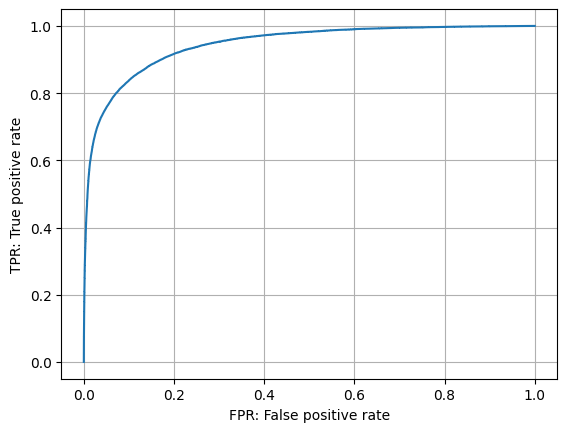

In [148]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
print("ROC:", roc_auc_score(y_true, y_pred))

plt.plot(fpr, tpr)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()